### Image Features
*Last updated: 18 Nov 2019*

Extracting image features from the CIFAR-10 dataset. Image feature extraction, or image descriptors, is an area of computer vision. Image descriptors include the likes of SIFT, KAZE, HOG, and SIFT. They can be used to classify images by similarity between descriptors. Since the number of descriptors per image will vary depending on the image, you can't directly compare descriptor 1 from image A to descriptor 1 from image B. Instead a "clustering" like strategy must be employed to allow comparisons (regression or classification). One common method to do this would be bag of visual words with K-means clustering or K-nearest neighbor clustering.

From a search of the web I found that you can use HOG features directly from scikit-image Python module, without the need of BOVW. I need to look more into what these features mean, and how we can interpret them. An example of this on the CIFAR-10 data can be found [here](https://github.com/jvizcar/BACH/blob/master/pipeline.py).

This notebook should create the features for all images and add them to the csv file as a feature column. For development purposes the feature columns will be named with the type of features included, in case we test a different set of features. In order to allow list of features to be stored in a dataframe cell and loaded back as a non-string we save pkl representations of the data.

In [1]:
from modules import utils
import matplotlib.pyplot as plt
from skimage.feature import hog
import numpy as np
import cv2
import pandas as pd
from tqdm.notebook import tqdm
import random
from sklearn.svm import LinearSVC

#### <center>HOG Features</center>

Extract features from training data and add as feature column

In [23]:
# extract features for all images in training dataset and add to csv
feature_limit = None
train_features = []
train_images = np.load('CIFAR10_Data/train.npy')
df_train = pd.read_csv('CIFAR10_Data/train.csv')

for i, r in tqdm(df_train.iterrows(), total=len(df_train)):
    train_features.append(utils.extract_features(train_images[i, :, :, :], 'hog', limit=feature_limit))

# add the feature column
df_train['hog_features'] = train_features
df_train.to_pickle('CIFAR10_Data/train.pkl')

Extract features from testing dta and add as feature column

In [25]:
feature_limit = None
test_features = []
test_images = np.load('CIFAR10_Data/test.npy')
df_test = pd.read_csv('CIFAR10_Data/test.csv')

for i, r in tqdm(df_test.iterrows(), total=len(df_test)):
    test_features.append(utils.extract_features(test_images[i, :, :, :], 'hog', limit=feature_limit))

# add the feature column
df_test['hog_features'] = test_features
df_test.to_pickle('CIFAR10_Data/test.pkl')

#### Sanity check visualization of the HOG features

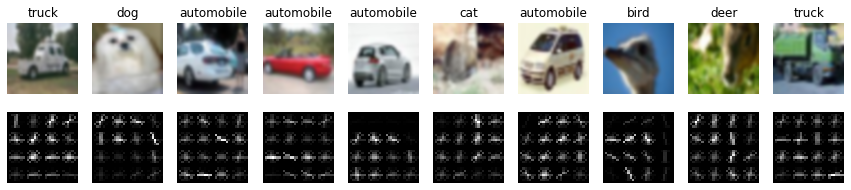

In [26]:
n = 10
fig, ax = plt.subplots(ncols=n, nrows=2, figsize=(15,3))
ax = ax.ravel()

# randomly sample n images from training data and visualize their HOG features (bottom row)
for i, idx in enumerate(random.sample(range(0, len(train_images)), n)):
    image = train_images[idx, :, :, :]
    ax[i].imshow(image, interpolation='bicubic')
    ax[i].set_title(df_train.loc[idx, 'label_name'], fontsize=12)
    ax[i].axis('off')
    
    image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    fd, hog_image = hog(image, visualize=True, orientations= 9, pixels_per_cell=[8,8], 
                    cells_per_block=[2,2], block_norm='L2-Hys', transform_sqrt=True)
    ax[i+n].imshow(hog_image, cmap='gray')
    ax[i+n].axis('off')
plt.show()

#### Sanity check that these features can be used to predict better than chance using support vector machine (SVM)

In [2]:
def simple_classifier(train_path, test_path, feature, subset=None):
    """Simple SVM classification training and testing score for sanity check that an extracted feature set
    is predictive of the data beyond chance. 
    
    :param train_path : str
        path to pickle file containing the labels and feature data
    :param test_path : str
        path to pickle file containing the testing data
    :param feature : str
        the name of the column containing the features
    
    :return score : float
        testing accuracy on the testing data
    """
    # load data
    train_data = pd.read_pickle(train_path)
    test_data = pd.read_pickle(test_path)
    
    if subset is not None:
        train_data = train_data[train_data['label'].isin(subset)]
        test_data = test_data[test_data['label'].isin(subset)]
    
    train_X = np.array(list(train_data[feature]))
    train_y = np.array(train_data['label'])
    
    test_X = np.array(list(test_data[feature]))
    test_y = np.array(test_data['label'])

    # use scikit-learn to train and predict on testing data with simple linear SVM
    C = 1.0
    clf = LinearSVC(C=C)
    clf.fit(train_X, train_y)
    score = clf.score(test_X, test_y)
    return score


score = simple_classifier('CIFAR10_Data/train.pkl', 'CIFAR10_Data/test.pkl', 'hog_features', subset=[0, 5])
print('Testing accuracy using HOG features: %.2f' % (score * 100))

Testing accuracy using HOG features: 93.50
